# Imports

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data getting, cleaning, and exploring
from acquire import get_connection, new_telco_data, get_telco_data
from prepare import clean_telco, impute_mode, train_validate_test_split,impute_mode, prep_telco_data
import explore

# Python without these is hard
import pandas as pd
import numpy as np
from pydataset import data

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz
from graphviz import Graph

## Get and clean data

In [2]:
df = clean_telco()

## Make sure it is correct

In [3]:
# 1 == "Yes", 0 == 'No'

df.head(2)

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,internet_service_type,payment_type,gender_male,one_year_contract,two_year_contract,credit_card_payment,e_check_payment,mailed_check_payment,dsl_internet,fiber_optic_internet
0,0,0,0,9,1,1,0,0,0,0,...,DSL,Mailed check,1,0,0,0,0,1,1,0
1,0,0,1,9,1,0,0,0,0,1,...,DSL,Credit card (automatic),0,0,0,1,0,0,1,0


In [4]:
df.shape

(7043, 27)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   senior_citizen         7043 non-null   int64  
 1   partner                7043 non-null   int64  
 2   dependents             7043 non-null   int64  
 3   tenure                 7043 non-null   int64  
 4   phone_service          7043 non-null   int64  
 5   multiple_lines         7043 non-null   int64  
 6   online_security        7043 non-null   int64  
 7   online_backup          7043 non-null   int64  
 8   device_protection      7043 non-null   int64  
 9   tech_support           7043 non-null   int64  
 10  streaming_tv           7043 non-null   int64  
 11  streaming_movies       7043 non-null   int64  
 12  paperless_billing      7043 non-null   int64  
 13  monthly_charges        7043 non-null   float64
 14  total_charges          7043 non-null   float64
 15  chur

## Establish categorical and quantitative data

In [6]:
quant_vars = ['tenure','monthly_charges','total_charges']
cat_vars = list((df.columns).drop(quant_vars))
target = 'churn'

## Split the data!

In [7]:
train, validate, test = train_validate_test_split(df)

In [8]:
# make sure all split data contains decreasing rows and equal columns

train.shape, validate.shape, test.shape

((3943, 27), (1691, 27), (1409, 27))

## Begin exploration!!!

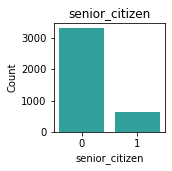

   senior_citizen  Count  Percent
0               0   3299    83.67
1               1    644    16.33
_________________________________________________________________


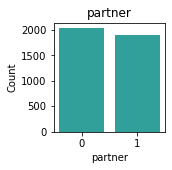

   partner  Count  Percent
0        0   2033    51.56
1        1   1910    48.44
_________________________________________________________________


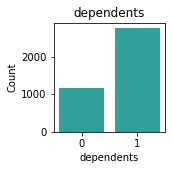

   dependents  Count  Percent
0           1   2764     70.1
1           0   1179     29.9
_________________________________________________________________


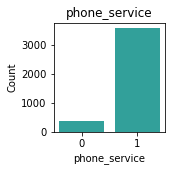

   phone_service  Count  Percent
1              1   3567    90.46
0              0    376     9.54
_________________________________________________________________


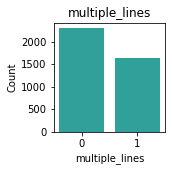

   multiple_lines  Count  Percent
0               0   2301    58.36
1               1   1642    41.64
_________________________________________________________________


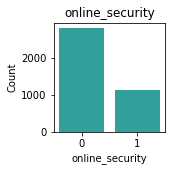

   online_security  Count  Percent
0                0   2804    71.11
1                1   1139    28.89
_________________________________________________________________


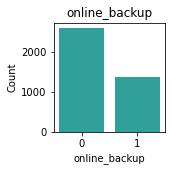

   online_backup  Count  Percent
0              0   2580    65.43
1              1   1363    34.57
_________________________________________________________________


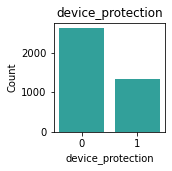

   device_protection  Count  Percent
0                  0   2610    66.19
1                  1   1333    33.81
_________________________________________________________________


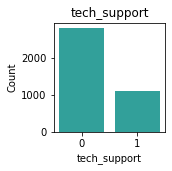

   tech_support  Count  Percent
0             0   2817    71.44
1             1   1126    28.56
_________________________________________________________________


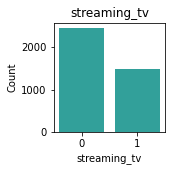

   streaming_tv  Count  Percent
0             0   2448    62.08
1             1   1495    37.92
_________________________________________________________________


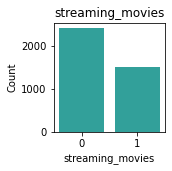

   streaming_movies  Count  Percent
0                 0   2417     61.3
1                 1   1526     38.7
_________________________________________________________________


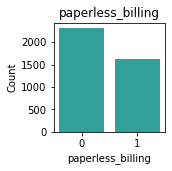

   paperless_billing  Count  Percent
1                  0   2310    58.58
0                  1   1633    41.42
_________________________________________________________________


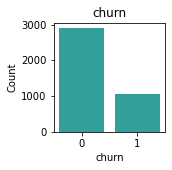

   churn  Count  Percent
0      0   2897    73.47
1      1   1046    26.53
_________________________________________________________________


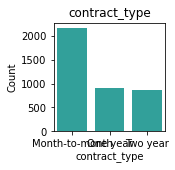

                 contract_type  Count  Percent
Month-to-month  Month-to-month   2166    54.93
Two year              One year    908    23.03
One year              Two year    869    22.04
_________________________________________________________________


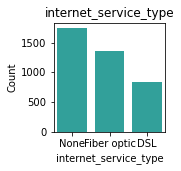

            internet_service_type  Count  Percent
Fiber optic                  None   1740    44.13
DSL                   Fiber optic   1365    34.62
None                          DSL    838    21.25
_________________________________________________________________


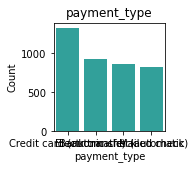

                                        payment_type  Count  Percent
Electronic check             Credit card (automatic)   1328    33.68
Mailed check                        Electronic check    923    23.41
Bank transfer (automatic)  Bank transfer (automatic)    860    21.81
Credit card (automatic)                 Mailed check    832    21.10
_________________________________________________________________


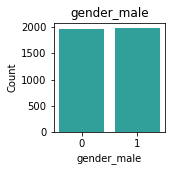

   gender_male  Count  Percent
1            1   1979    50.19
0            0   1964    49.81
_________________________________________________________________


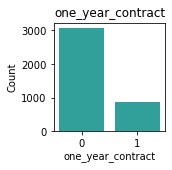

   one_year_contract  Count  Percent
0                  0   3074    77.96
1                  1    869    22.04
_________________________________________________________________


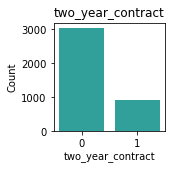

   two_year_contract  Count  Percent
0                  0   3035    76.97
1                  1    908    23.03
_________________________________________________________________


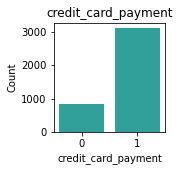

   credit_card_payment  Count  Percent
0                    1   3111     78.9
1                    0    832     21.1
_________________________________________________________________


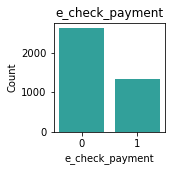

   e_check_payment  Count  Percent
0                0   2615    66.32
1                1   1328    33.68
_________________________________________________________________


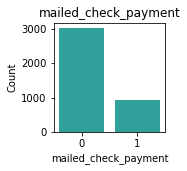

   mailed_check_payment  Count  Percent
0                     0   3020    76.59
1                     1    923    23.41
_________________________________________________________________


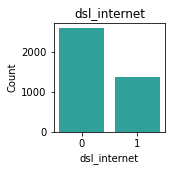

   dsl_internet  Count  Percent
0             0   2578    65.38
1             1   1365    34.62
_________________________________________________________________


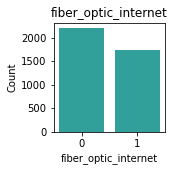

   fiber_optic_internet  Count  Percent
0                     0   2203    55.87
1                     1   1740    44.13
_________________________________________________________________


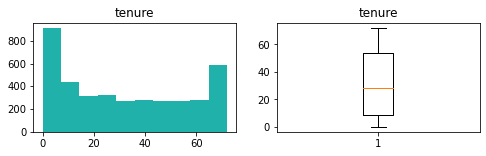

count    3943.000000
mean       31.931017
std        24.365751
min         0.000000
25%         9.000000
50%        28.000000
75%        54.000000
max        72.000000
Name: tenure, dtype: float64


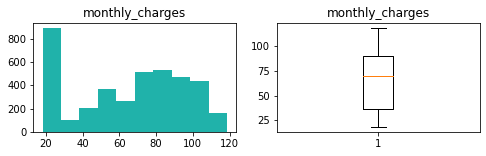

count    3943.000000
mean       64.823497
std        29.942691
min        18.250000
25%        36.350000
50%        70.150000
75%        89.750000
max       118.600000
Name: monthly_charges, dtype: float64


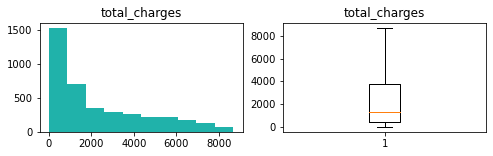

count    3943.000000
mean     2257.252346
std      2263.080704
min         0.000000
25%       400.700000
50%      1346.900000
75%      3722.775000
max      8684.800000
Name: total_charges, dtype: float64


In [21]:
explore.explore_univariate(train, cat_vars, quant_vars)

### Takeaways from univariate:
#### Observations:
- There are significantly more non-senior citizens than senior citizens
- There are a lot more customers with dependents
- Significantly more customers with phone service than without
- Less have online security, online backup, device protection, and tech support
- A lot more people churn than stay
- More customers are Month-to-month than in contracts
- Electronis check is the most popular payment method

#### Questions:
- Customers with phone service that have multiple lines?
- Customers with internet that have online services (i.e. online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies)

senior_citizen 
_____________________

        chi2       p-value  degrees of freedom
0  57.427698  3.506345e-14                   1

observed:
 churn              0     1   All
senior_citizen                  
0               2502   797  3299
1                395   249   644
All             2897  1046  3943

expected:
              0           1
0  2423.840477  875.159523
1   473.159523  170.840477


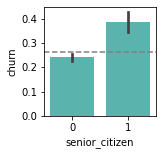


_____________________

partner 
_____________________

        chi2       p-value  degrees of freedom
0  81.646173  1.627667e-19                   1

observed:
 churn       0     1   All
partner                  
0        1368   665  2033
1        1529   381  1910
All      2897  1046  3943

expected:
              0           1
0  1493.685265  539.314735
1  1403.314735  506.685265


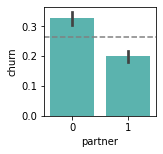


_____________________

dependents 
_____________________

        chi2       p-value  degrees of freedom
0  91.289781  1.240999e-21                   1

observed:
 churn          0     1   All
dependents                  
0           1909   855  2764
1            988   191  1179
All         2897  1046  3943

expected:
              0           1
0  2030.765407  733.234593
1   866.234593  312.765407


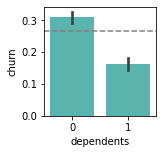


_____________________

phone_service 
_____________________

       chi2  p-value  degrees of freedom
0  0.158869   0.6902                   1

observed:
 churn             0     1   All
phone_service                  
0               280    96   376
1              2617   950  3567
All            2897  1046  3943

expected:
              0           1
0   276.254628   99.745372
1  2620.745372  946.254628


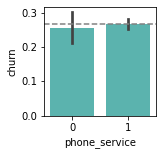


_____________________

multiple_lines 
_____________________

       chi2  p-value  degrees of freedom
0  5.115686  0.02371                   1

observed:
 churn              0     1   All
multiple_lines                  
0               1722   579  2301
1               1175   467  1642
All             2897  1046  3943

expected:
             0          1
0  1690.59016  610.40984
1  1206.40984  435.59016


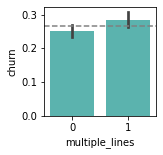


_____________________

online_security 
_____________________

         chi2       p-value  degrees of freedom
0  114.851907  8.479963e-27                   1

observed:
 churn               0     1   All
online_security                  
0                1925   879  2804
1                 972   167  1139
All              2897  1046  3943

expected:
              0           1
0  2060.154197  743.845803
1   836.845803  302.154197


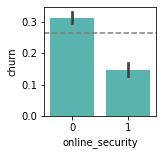


_____________________

online_backup 
_____________________

        chi2   p-value  degrees of freedom
0  13.856071  0.000197                   1

observed:
 churn             0     1   All
online_backup                  
0              1846   734  2580
1              1051   312  1363
All            2897  1046  3943

expected:
              0           1
0  1895.576972  684.423028
1  1001.423028  361.576972


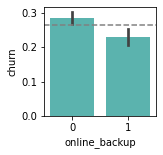


_____________________

device_protection 
_____________________

        chi2   p-value  degrees of freedom
0  16.406735  0.000051                   1

observed:
 churn                 0     1   All
device_protection                  
0                  1864   746  2610
1                  1033   300  1333
All                2897  1046  3943

expected:
              0           1
0  1917.618565  692.381435
1   979.381435  353.618565


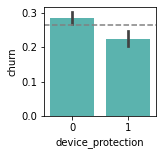


_____________________

tech_support 
_____________________

         chi2       p-value  degrees of freedom
0  111.474188  4.658311e-26                   1

observed:
 churn            0     1   All
tech_support                  
0             1937   880  2817
1              960   166  1126
All           2897  1046  3943

expected:
              0           1
0  2069.705554  747.294446
1   827.294446  298.705554


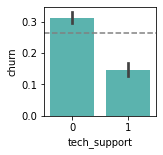


_____________________

streaming_tv 
_____________________

        chi2   p-value  degrees of freedom
0  14.324719  0.000154                   1

observed:
 churn            0     1   All
streaming_tv                  
0             1850   598  2448
1             1047   448  1495
All           2897  1046  3943

expected:
              0           1
0  1798.593964  649.406036
1  1098.406036  396.593964


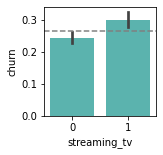


_____________________

streaming_movies 
_____________________

       chi2   p-value  degrees of freedom
0  9.992303  0.001572                   1

observed:
 churn                0     1   All
streaming_movies                  
0                 1819   598  2417
1                 1078   448  1526
All               2897  1046  3943

expected:
              0           1
0  1775.817652  641.182348
1  1121.182348  404.817652


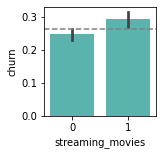


_____________________

paperless_billing 
_____________________

        chi2       p-value  degrees of freedom
0  140.22847  2.372755e-32                   1

observed:
 churn                 0     1   All
paperless_billing                  
0                  1362   271  1633
1                  1535   775  2310
All                2897  1046  3943

expected:
              0           1
0  1199.797362  433.202638
1  1697.202638  612.797362


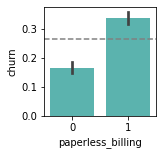


_____________________

churn 
_____________________

          chi2  p-value  degrees of freedom
0  3937.871007      0.0                   1

observed:
 churn     0     1   All
churn                  
0      2897     0  2897
1         0  1046  1046
All    2897  1046  3943

expected:
              0           1
0  2128.483135  768.516865
1   768.516865  277.483135


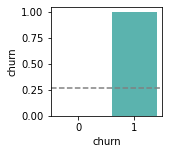


_____________________

contract_type 
_____________________

         chi2        p-value  degrees of freedom
0  630.335702  1.331501e-137                   2

observed:
 churn              0     1   All
contract_type                   
Month-to-month  1251   915  2166
One year         762   107   869
Two year         884    24   908
All             2897  1046  3943

expected:
              0           1
0  1591.402993  574.597007
1   638.471468  230.528532
2   667.125539  240.874461


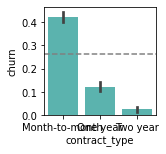


_____________________

internet_service_type 
_____________________

         chi2       p-value  degrees of freedom
0  398.382058  3.107673e-87                   2

observed:
 churn                     0     1   All
internet_service_type                  
DSL                    1106   259  1365
Fiber optic            1016   724  1740
None                    775    63   838
All                    2897  1046  3943

expected:
              0           1
0  1002.892468  362.107532
1  1278.412376  461.587624
2   615.695156  222.304844


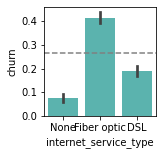


_____________________

payment_type 
_____________________

         chi2       p-value  degrees of freedom
0  324.547348  4.834481e-70                   3

observed:
 churn                         0     1   All
payment_type                               
Bank transfer (automatic)   700   160   860
Credit card (automatic)     706   126   832
Electronic check            741   587  1328
Mailed check                750   173   923
All                        2897  1046  3943

expected:
             0           1
0  631.858991  228.141009
1  611.286837  220.713163
2  975.707837  352.292163
3  678.146335  244.853665


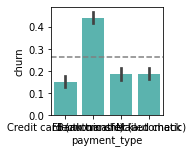


_____________________

gender_male 
_____________________

       chi2  p-value  degrees of freedom
0  0.156854  0.69207                   1

observed:
 churn           0     1   All
gender_male                  
0            1437   527  1964
1            1460   519  1979
All          2897  1046  3943

expected:
              0           1
0  1442.989602  521.010398
1  1454.010398  524.989602


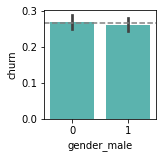


_____________________

one_year_contract 
_____________________

         chi2       p-value  degrees of freedom
0  114.627334  9.496796e-27                   1

observed:
 churn                 0     1   All
one_year_contract                  
0                  2135   939  3074
1                   762   107   869
All                2897  1046  3943

expected:
              0           1
0  2258.528532  815.471468
1   638.471468  230.528532


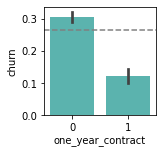


_____________________

two_year_contract 
_____________________

         chi2       p-value  degrees of freedom
0  343.690562  1.002639e-76                   1

observed:
 churn                 0     1   All
two_year_contract                  
0                  2013  1022  3035
1                   884    24   908
All                2897  1046  3943

expected:
              0           1
0  2229.874461  805.125539
1   667.125539  240.874461


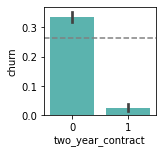


_____________________

credit_card_payment 
_____________________

        chi2       p-value  degrees of freedom
0  69.374518  8.143400e-17                   1

observed:
 churn                   0     1   All
credit_card_payment                  
0                    2191   920  3111
1                     706   126   832
All                  2897  1046  3943

expected:
              0           1
0  2285.713163  825.286837
1   611.286837  220.713163


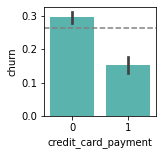


_____________________

e_check_payment 
_____________________

         chi2       p-value  degrees of freedom
0  319.545884  1.818937e-71                   1

observed:
 churn               0     1   All
e_check_payment                  
0                2156   459  2615
1                 741   587  1328
All              2897  1046  3943

expected:
              0           1
0  1921.292163  693.707837
1   975.707837  352.292163


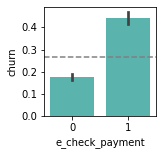


_____________________

mailed_check_payment 
_____________________

        chi2       p-value  degrees of freedom
0  36.950819  1.211468e-09                   1

observed:
 churn                    0     1   All
mailed_check_payment                  
0                     2147   873  3020
1                      750   173   923
All                   2897  1046  3943

expected:
              0           1
0  2218.853665  801.146335
1   678.146335  244.853665


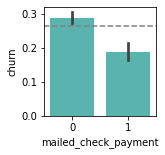


_____________________

dsl_internet 
_____________________

        chi2       p-value  degrees of freedom
0  60.526153  7.260737e-15                   1

observed:
 churn            0     1   All
dsl_internet                  
0             1791   787  2578
1             1106   259  1365
All           2897  1046  3943

expected:
              0           1
0  1894.107532  683.892468
1  1002.892468  362.107532


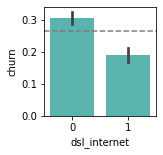


_____________________

fiber_optic_internet 
_____________________

         chi2       p-value  degrees of freedom
0  362.033241  1.015910e-80                   1

observed:
 churn                    0     1   All
fiber_optic_internet                  
0                     1881   322  2203
1                     1016   724  1740
All                   2897  1046  3943

expected:
              0           1
0  1618.587624  584.412376
1  1278.412376  461.587624


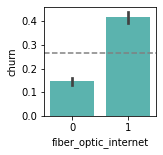


_____________________

tenure 
____________________



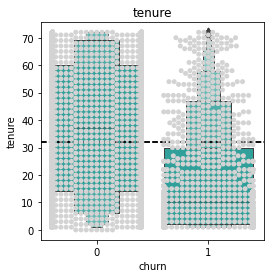

        count       mean        std  min   25%   50%   75%   max
churn                                                           
0      2897.0  36.940283  23.962669  0.0  14.0  37.0  60.0  72.0
1      1046.0  18.057361  19.647335  1.0   2.0  10.0  30.0  72.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2225608.5, pvalue=2.4298450761804645e-112)

____________________

monthly_charges 
____________________



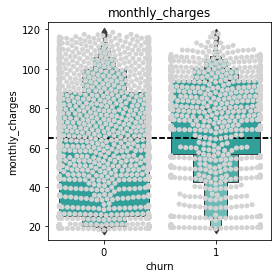

        count       mean        std    min      25%    50%    75%     max
churn                                                                    
0      2897.0  61.413997  30.890138  18.25  25.1500  64.60  88.40  118.60
1      1046.0  74.266444  24.823691  18.85  56.6625  79.65  94.25  118.35 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1156450.0, pvalue=6.206014591716352e-30)

____________________

total_charges 
____________________



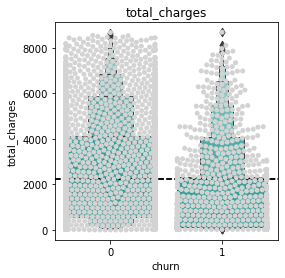

        count         mean          std    min       25%       50%       75%  \
churn                                                                          
0      2897.0  2518.846634  2324.718351   0.00  562.7000  1615.100  4144.900   
1      1046.0  1532.741205  1904.635962  18.85  114.5625   712.925  2319.125   

          max  
churn          
0      8670.1  
1      8684.8   


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1963969.0, pvalue=6.658335647991753e-46)

____________________



In [9]:
explore.explore_bivariate(train, 'churn', cat_vars, quant_vars)

### Bivariate:
#### Observations:
- REALLY LOW p-values
    - senior, partner, dependents, online_security, tech_support, paperless_billing, ***month-to_month***, fiber_optic_internet, one_year, two_year
- Real low p-values
    - online_backup, device_protection, streaming_tv, streaming_movies, 
- barely passes 95% confidence
    - multiple lines
- Not low
    - gender, phone_service
- Vast majority of churn happens before 30 months
- higher monthly bill increases churn

#### Questions:
- Do people with all online services churn more than customers without all of the online services?
- Are the really low p-values a good starting point?

In [34]:
train.shape

(3943, 27)

In [35]:
train[train.internet_service_type != "None"].shape

(3105, 27)